In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import nltk
from nltk.stem import WordNetLemmatizer
from sklearn.decomposition import TruncatedSVD

nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Load data

In [4]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

book_titles = [line.rstrip().encode('ascii', 'ignore').decode('utf-8') for line in open('/content/gdrive/MyDrive/Colab Notebooks/lazyprogrammer/data/all_book_titles.txt')]

stopwords = set(w.rstrip() for w in open('/content/gdrive/MyDrive/Colab Notebooks/lazyprogrammer/data/electronics/stopwords.txt'))
# note: an alternative source of stopwords
# from nltk.corpus import stopwords
# stopwords.words('english')
stopwords = stopwords.union({
    'introduction', 'edition', 'series', 'application',
    'approach', 'card', 'access', 'package', 'plus', 'etext',
    'brief', 'vol', 'fundamental', 'guide', 'essential', 'printed',
    'third', 'second', 'fourth', })

len(book_titles)

Mounted at /content/gdrive/


2373

# Utils

In [5]:
def tokenize(txt, lemmatizer):
  tokens = nltk.tokenize.word_tokenize(txt.lower())
  tokens = [t for t in tokens if len(t) > 2]
  tokens = [lemmatizer.lemmatize(t) for t in tokens]
  tokens = [t for t in tokens if t not in stopwords]
  tokens = [t for t in tokens if not any(c.isdigit() for c in t)] # remove any digits, i.e. "3rd edition"
  return tokens

def build_token_idx_dictionaries(txts, lemmatizer):
  token_id = 0
  token2idx = {}
  idx2token = {}
  for txt in txts:
    for token in tokenize(txt, lemmatizer):
      if token not in token2idx:
        token2idx[token] = token_id
        idx2token[token_id] = token
        token_id += 1
  return token2idx, idx2token

def tokenize_book_titles(txts, lemmatizer):
  return [tokenize(txt, lemmatizer) for txt in txts]

def build_bag_of_wrods_vectorizer(tokens, token2idx):
  x = np.zeros(len(token2idx))
  for t in tokens:
    token_id = token2idx[t]
    x[token_id] = 1
  return x

def vectorize_book_titles(txts, token2idx):
  return [build_bag_of_wrods_vectorizer(txt, token2idx) for txt in txts]

def process_book_titles(txts, token2idx, lemmatizer):
  tokenized_book_titles = tokenize_book_titles(txts, lemmatizer)
  return vectorize_book_titles(tokenized_book_titles, token2idx)

# Process data

In [6]:
lemmatizer = WordNetLemmatizer()
token2idx, idx2token = build_token_idx_dictionaries(book_titles, lemmatizer)
V = len(token2idx)

print('vocab size:', V, '\n')
print('Example of oryginal book titles:')
book_titles[:3]

vocab size: 2070 

Example of oryginal book titles:


['Philosophy of Sex and Love A Reader',
 'Readings in Judaism, Christianity, and Islam',
 'Microprocessors Principles and Applications']

In [7]:
book_titles_vectrorized = process_book_titles(book_titles, token2idx, lemmatizer)
book_titles_vectrorized[:3]

[array([1., 1., 1., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.])]

# Dimention reduction

In [15]:
N = len(book_titles_vectrorized)
D = len(token2idx)
X = np.zeros((D, N)) # terms will go along rows, documents along columns
for i, x in enumerate(book_titles_vectrorized):
    X[:, i] = x

X[:, :3].sum(axis=0)

array([4., 4., 2.])

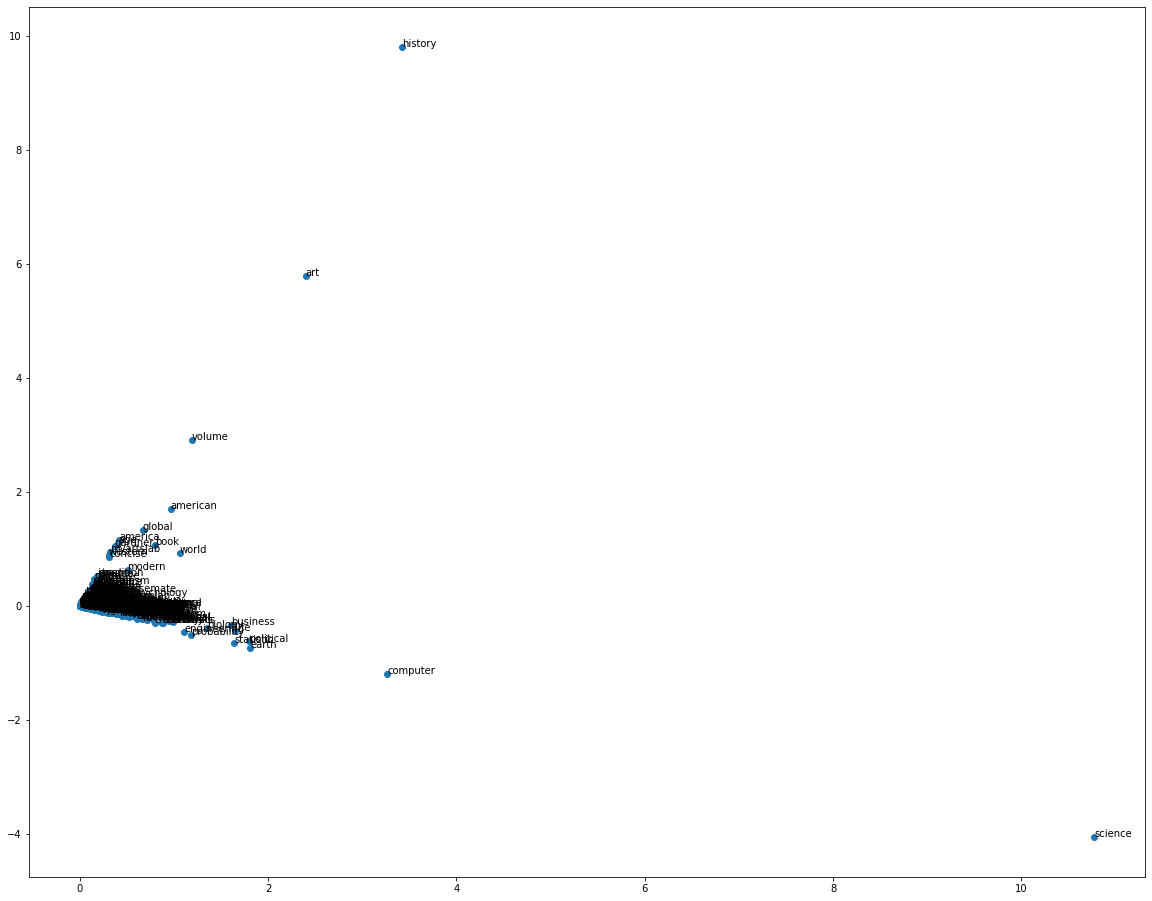

In [21]:
svd = TruncatedSVD()
Z = svd.fit_transform(X)
plt.figure(figsize=(20,16))
plt.scatter(Z[:,0], Z[:,1])

for i in range(D):
  plt.annotate(s=idx2token[i], xy=(Z[i,0], Z[i,1]))
plt.show();